In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [8]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

## Size distribution 
1. Subtract background contribution
2. Correct for completeness

In [38]:
from paper_figure import plot_size_distribution_new
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

### The size distribution of UDGs and UPGs (as of 2022-12-12)

In [41]:
date = '221025'

Total angular area [deg2]: 32.70887732960614
Total angular area [deg2]: 32.70887732960614


sample: 100%|██████████████████| 6000/6000 [00:05<00:00, 1181.52it/s, 15 steps of size 2.10e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -1.45      0.20     -1.45     -1.77     -1.13    856.37      1.00
         b      0.94      0.07      0.94      0.82      1.06    840.31      1.00

Number of divergences: 0
Total angular area [deg2]: 32.36912377009267
Total angular area [deg2]: 32.36912377009267


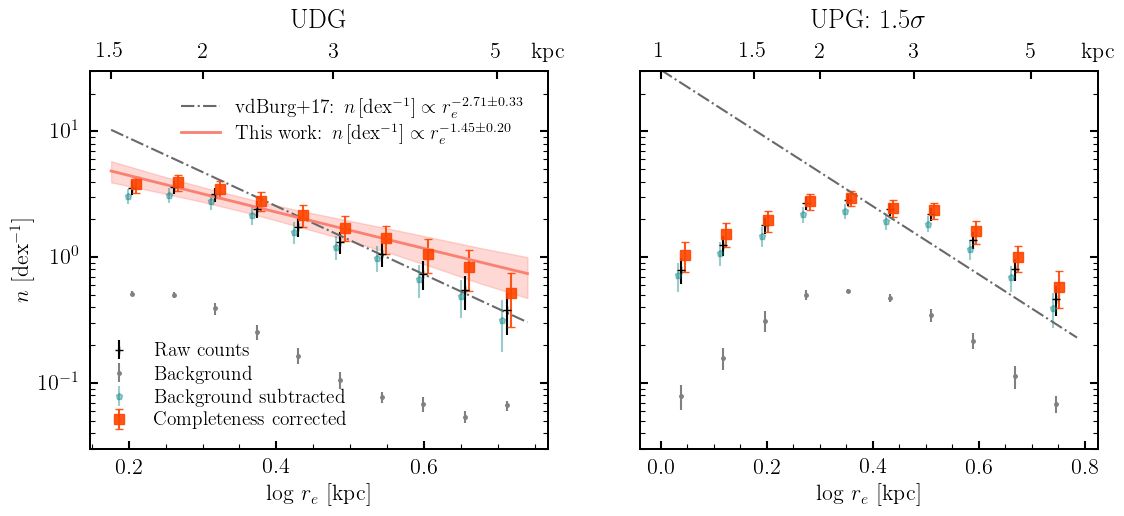

In [44]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{date}.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

fig, ax1 = plot_size_distribution_new(udg_cat, fake_udg_cat, total_area, 24, 
                                      fake_udg_repeats=10*20, name='UDG', ax=ax1, 
                                      range_0=np.array([np.log10(1.5), np.log10(5.5)]),
                                      fit_line=True, refit=True, verbose=True)
ax1.set_ylim(0.03, 30)
xlim = ax1.get_xlim()
# plt.text(0.13 * (xlim[1] - xlim[0]) + xlim[0], 13, 'UDG', fontsize=20,
#          bbox=dict(facecolor='w', alpha=1, edgecolor='none'))

ax1.set_title('UDG')
ax2.set_title('UPG: $1.5\sigma$')


### UPG ###
name = 'upg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = 1.5

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

fig, ax2 = plot_size_distribution_new(udg_cat, fake_udg_cat, total_area, 24, 
                                  fake_udg_repeats=10*20, name='UPG_1.5sigma', ax=ax2, fit_line=False,
                                  range_0=np.array([np.log10(1), np.log10(6.1)]), 
                                  dots_legend=False, nolinelegend=True)
ax2.set_ylabel('')

import matplotlib
y_minor = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10)
ax2.yaxis.set_minor_locator(y_minor)
ax2.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# plt.tight_layout()
plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/size_distribution.pdf', 
            bbox_inches='tight', dpi=50)

### Whether the size distribution of UDG is a function of distance to the hosts

In [30]:
date = '221025'

Total angular area [deg2]: 32.70887732960614
Total angular area [deg2]: 19.878248857317743
Total angular area [deg2]: 23.491273772921666


Text(0.23275044661950423, 13, 'UDG')

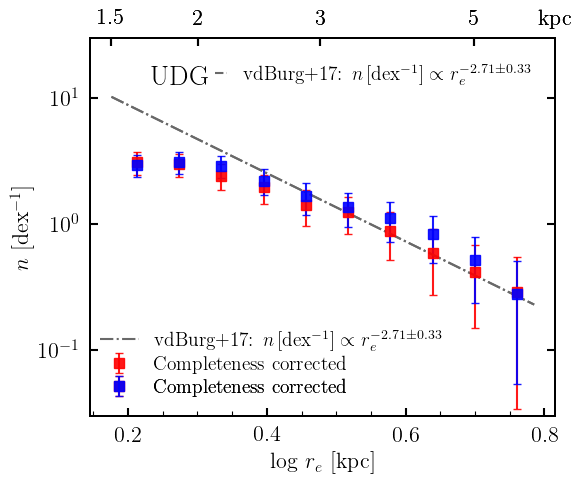

In [36]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5), sharey=True)

name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{date}.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]


udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data


temp = udg_cat[dist_ratio >= 0.5]
fig, ax1 = plot_size_distribution_new(temp, fake_udg_cat, total_area, 24, 
                                  fake_udg_repeats=10*20, name='UDG', ax=ax1, color='r',
                                  fit_line=False, refit=True, verbose=True, only_result=True)

temp = udg_cat[dist_ratio <= 0.5]
fig, ax1 = plot_size_distribution_new(temp, fake_udg_cat, total_area, 24, 
                                  fake_udg_repeats=10*20, name='UDG', ax=ax1, color='b',
                                  fit_line=False, refit=True, verbose=True, only_result=True)

ax1.set_ylim(0.03, 30)
xlim = ax1.get_xlim()
plt.text(0.13 * (xlim[1] - xlim[0]) + xlim[0], 13, 'UDG', fontsize=20,
         bbox=dict(facecolor='w', alpha=1, edgecolor='none'))

Total angular area [deg2]: 32.36912377009267
Total angular area [deg2]: 19.900315494420774
Total angular area [deg2]: 19.705923243317258


Text(0.23275044661950423, 13, 'UPG')

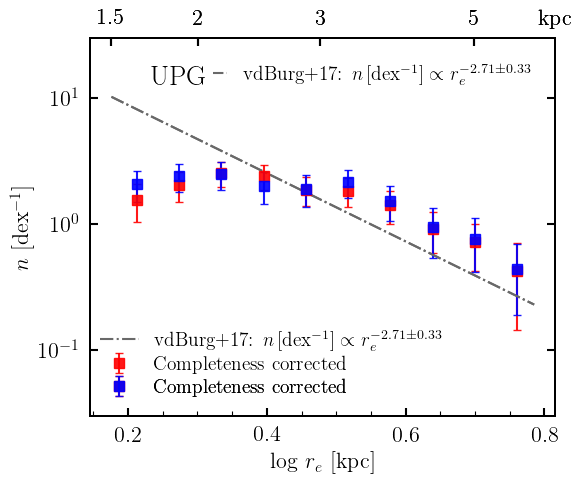

In [37]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5), sharey=True)

name = 'upg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = 1.5

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]


udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data


temp = udg_cat[dist_ratio >= 0.5]
fig, ax1 = plot_size_distribution_new(temp, fake_udg_cat, total_area, 24, 
                                  fake_udg_repeats=10*20, name='UDG', ax=ax1, color='r',
                                  fit_line=False, refit=True, verbose=True, only_result=True)

temp = udg_cat[dist_ratio <= 0.5]
fig, ax1 = plot_size_distribution_new(temp, fake_udg_cat, total_area, 24, 
                                  fake_udg_repeats=10*20, name='UDG', ax=ax1, color='b',
                                  fit_line=False, refit=True, verbose=True, only_result=True)

ax1.set_ylim(0.03, 30)
xlim = ax1.get_xlim()
plt.text(0.13 * (xlim[1] - xlim[0]) + xlim[0], 13, 'UPG', fontsize=20,
         bbox=dict(facecolor='w', alpha=1, edgecolor='none'))

## No difference!

---

---

## Spatial distribution

In [5]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw, profile_einasto
from sample_cuts import moving_binned_statistic
from paper_figure import plot_radial_number_profile

Deleted outdated persistence file, no further action needed.
-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 9 steps. Best-fit parameters:
Parameter       rhos = 6.83e+01 [2.75e+01 .. 1.69e+02]
Parameter         rs = 1.17e-01 [8.26e-02 .. 1.65e-01]
chi2 / Ndof = 16.7 / 11 = 1.52
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Profile fit: Varying 3 / 3 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 29 steps. Best-fit parameters:
Parameter       rhos = 2.01e+00 [9.89e-01 .. 4.07e+00]
Parameter         rs = 3.05e-01 [2.18e-01 .. 4.26e-01]
Parameter      alpha = 4.42e-01 [2.69e-01 .. 7.27e-01]
chi2 / Ndof = 7.2 / 10 = 0.72
--------------------------------------

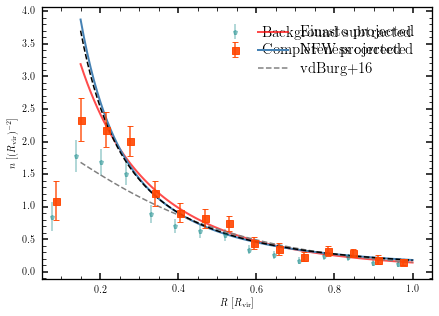

In [6]:
fig, ax = plt.subplots(figsize=(7, 5), sharey=True)

name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

fig, ax = plot_radial_number_profile(udg_cat, fake_udg_cat, 24, n_bins=15,
                                     fake_udg_repeats=10*20, name='UDG', ax=ax, r_min=0.15,
                                     refit=True, verbose=True)
plt.xlim(0.05, 1.05)

from colossus.cosmology import cosmology
from colossus.halo import profile_nfw, profile_einasto

p_ein_vdb = profile_einasto.EinastoProfile(
        rhos=22, alpha=0.15, rs=0.1, z=0.0, mdef='vir')

r = np.linspace(0.15, 1, 100)
line3 = plt.plot(r, p_ein_vdb.surfaceDensity(r), color='k',
                 label='Halo', ls='--')

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/radial_distribution.pdf',
#             bbox_inches='tight', dpi=50)

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 9 steps. Best-fit parameters:
Parameter       rhos = 7.07e+01 [2.31e+01 .. 2.17e+02]
Parameter         rs = 1.14e-01 [7.46e-02 .. 1.75e-01]
chi2 / Ndof = 59.6 / 20 = 2.98
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Profile fit: Varying 3 / 3 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 20 steps. Best-fit parameters:
Parameter       rhos = 3.21e+00 [7.34e-01 .. 1.41e+01]
Parameter         rs = 2.42e-01 [1.23e-01 .. 4.78e-01]
Parameter      alpha = 3.32e-01 [1.52e-01 .. 7.25e-01]
chi2 / Ndof = 31.1 / 19 = 1.64
-------------------------------------------------------------------------------------
NFW conc = 8

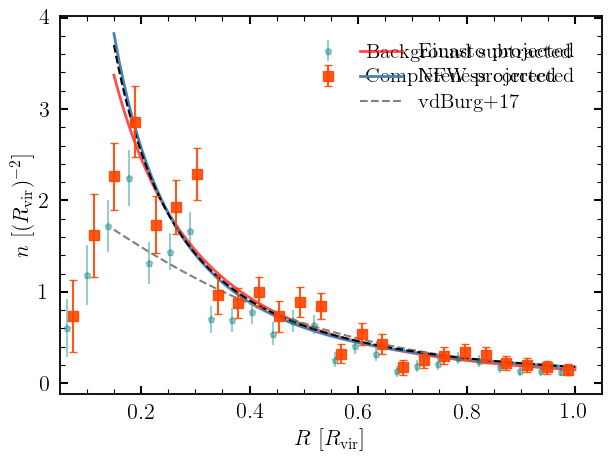

In [130]:
fig, ax = plt.subplots(figsize=(7, 5), sharey=True)

name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

fig, ax = plot_radial_number_profile(udg_cat, fake_udg_cat, 24, n_bins=15,
                                     fake_udg_repeats=10*20, name='UDG', ax=ax, r_min=0.15,
                                     refit=True, verbose=True)
plt.xlim(0.05, 1.05)

from colossus.cosmology import cosmology
from colossus.halo import profile_nfw, profile_einasto

p_ein_vdb = profile_einasto.EinastoProfile(
        rhos=22, alpha=0.15, rs=0.1, z=0.0, mdef='vir')

r = np.linspace(0.15, 1, 100)
line3 = plt.plot(r, p_ein_vdb.surfaceDensity(r), color='k',
                 label='Halo', ls='--')

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/radial_distribution.pdf',
#             bbox_inches='tight', dpi=50)

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 9 steps. Best-fit parameters:
Parameter       rhos = 1.10e+02 [2.20e+01 .. 5.55e+02]
Parameter         rs = 9.17e-02 [5.04e-02 .. 1.67e-01]
chi2 / Ndof = 17.1 / 9 = 1.90
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Profile fit: Varying 3 / 3 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 29 steps. Best-fit parameters:
Parameter       rhos = 2.00e+00 [4.28e-01 .. 9.37e+00]
Parameter         rs = 2.81e-01 [1.39e-01 .. 5.69e-01]
Parameter      alpha = 3.98e-01 [1.64e-01 .. 9.64e-01]
chi2 / Ndof = 9.0 / 8 = 1.12
-------------------------------------------------------------------------------------
NFW conc = 10.9

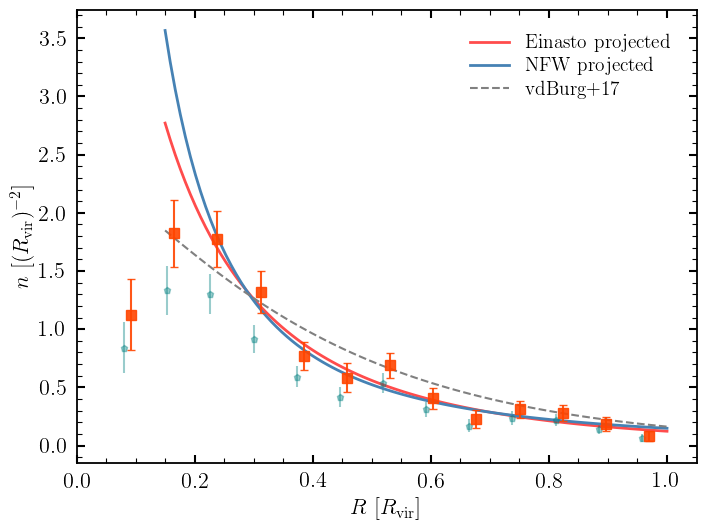

In [77]:
name = 'upg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = 1.5

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]


fig, ax = plot_radial_number_profile(udg_cat, fake_udg_cat, 24, n_bins=13,
                                     fake_udg_repeats=10*20, name='UPG_1.5sigma', r_min=0.23,
                                     refit=True, verbose=True, dots_legend=False, lines_legend=True)

---

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 10 steps. Best-fit parameters:
Parameter       rhos = 1.06e+02 [2.78e+01 .. 4.01e+02]
Parameter         rs = 9.95e-02 [6.05e-02 .. 1.64e-01]
chi2 / Ndof = 16.3 / 9 = 1.81
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Profile fit: Varying 3 / 3 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 20 steps. Best-fit parameters:
Parameter       rhos = 2.03e+00 [7.08e-01 .. 5.81e+00]
Parameter         rs = 3.03e-01 [1.86e-01 .. 4.94e-01]
Parameter      alpha = 4.40e-01 [2.23e-01 .. 8.69e-01]
chi2 / Ndof = 7.5 / 8 = 0.94
-------------------------------------------------------------------------------------
NFW conc = 10.

Text(0.65, 1.6, '$c_{\\rm Ein} = 3.55^{+3.63}_{-1.80}$')

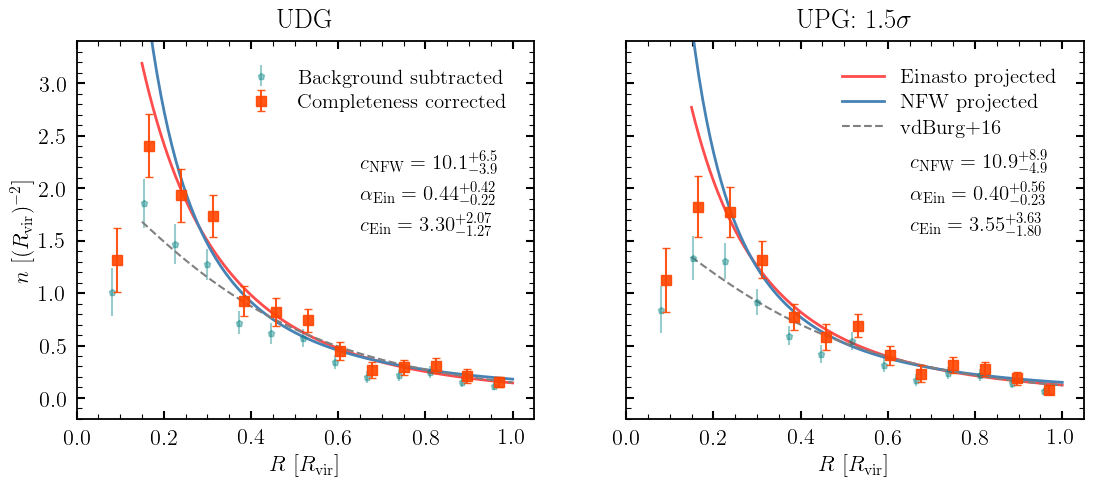

In [131]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

fig, ax1 = plot_radial_number_profile(udg_cat, fake_udg_cat, 24, n_bins=13,
                                     fake_udg_repeats=10*20, name='UDG', ax=ax1, r_min=0.2,
                                     refit=True, verbose=True, dots_legend=True, lines_legend=False)
ax1.set_ylim(-0.2, 3.4)
ax1.text(0.65, 2.2, r'$c_{\rm NFW} = 10.1^{+6.5}_{-3.9}$', fontsize=15)
ax1.text(0.65, 1.9, r'$\alpha_{\rm Ein} = 0.44^{+0.42}_{-0.22}$', fontsize=15)
ax1.text(0.65, 1.6, r'$c_{\rm Ein} = 3.30^{+2.07}_{-1.27}$', fontsize=15)

# ### UPG ###
name = 'upg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = 1.5

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]


fig, ax2 = plot_radial_number_profile(udg_cat, fake_udg_cat, 24, n_bins=13,
                                     fake_udg_repeats=10*20, name='UPG_1.5sigma', ax=ax2, r_min=0.2,
                                      amp_vdb16=0.4,
                                     refit=True, verbose=True, dots_legend=False, lines_legend=True)
ax2.set_ylabel('')
ax1.set_title('UDG')
ax2.set_title('UPG: $1.5\sigma$')
ax2.set_ylim(-0.2, 3.4)

ax2.text(0.65, 2.2, r'$c_{\rm NFW} = 10.9^{+8.9}_{-4.9}$', fontsize=15)
ax2.text(0.65, 1.9, r'$\alpha_{\rm Ein} = 0.40^{+0.56}_{-0.23}$', fontsize=15)
ax2.text(0.65, 1.6, r'$c_{\rm Ein} = 3.55^{+3.63}_{-1.80}$', fontsize=15)

# # plt.tight_layout()
# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/radial_distribution.pdf',
#             bbox_inches='tight', dpi=50)

---

In [8]:
Table.read('./Catalog/Greco_S18A_lsbg.fits')

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
215.8329984,0.2811588,28.216,9.562,-35.3,0.661,21.1729,19.8098,19.1529,4.453428000000001,10.171812000000001,25.633491911544482,25.738705501484027,1.2945062224264043,1.1972487376441967,0.7420092057952641,0.08851553892135328,0.06272474471661625,0.04476427656554674,9615,"7,1",-1,1,0,0,1,1,0,0,2,0,2
147.3708919,1.9053533,19.794,5.394,-86.94,0.727,19.5774,19.0889,18.8573,3.2108160000000003,3.049704,23.266714234788807,22.483917478891495,1.5028572178870752,0.6248699376374405,0.43206613345085754,0.2163359772328874,0.1533021106837442,0.10940591487032814,9811,"3,2",-1,2,1,1,0,1,0,0,3,2,1
1.5874696,-0.6431355,5.924,3.885,35.07,0.344,22.7053,22.4468,22.3615,3.328752,3.4971720000000004,26.43127645943667,25.112169832403893,1.8173340300296321,0.23490671375315236,-0.059199797024110934,0.09163529063583262,0.06493549361172055,0.04634200438898432,9227,"3,5",-1,4,0,0,0,0,0,2,2,0,2
242.4089261,42.2002285,12.746,11.401,14.69,0.105,19.1545,18.6204,18.3382,2.714208,2.5971960000000003,22.85556614436461,21.92943946109086,1.1515187051307707,0.8109552956646501,0.5359807812991878,0.036102583927527986,0.025583365226714075,0.018257879592177003,15830,"5,3",-1,5,1,1,0,0,0,0,2,2,0
128.225899,-1.3695901,21.903,10.155,37.54,0.536,20.2717,19.6992,19.2554,10.311000000000002,19.060272,26.7160636748527,27.574008354500663,1.4548696438400008,-0.015669188796916117,0.11200176730494567,0.09300274554470038,0.06590451284964693,0.047033556747783825,9312,"0,1",-1,6,0,0,0,0,0,2,2,0,2
139.80392,3.468837,12.956,10.356,32.72,0.201,19.8244,18.9245,18.5328,2.6764920000000005,2.515632,23.440664571855944,22.045006082821665,1.155435208607804,1.2434800646263586,0.864766345981248,0.1305337616163841,0.09250010759762944,0.06601382624274296,10048,"4,3",-1,7,1,1,0,0,0,0,2,2,0
147.5442306,-1.0308062,8.511,6.224,22.7,0.269,22.1464,20.3646,19.6905,6.071604000000001,8.57892,27.353989952633498,26.253526182371512,1.4530627274631271,0.4437670628513678,0.3913235126445471,0.1969195155203557,0.13954302816490408,0.09958657837172334,9326,"7,2",-1,8,0,0,0,0,0,2,2,0,2
343.4162792,1.334467,6.966,4.996,85.45,0.283,22.7485,21.8327,21.554,3.987228,3.3282480000000003,27.128905408179342,25.84863871402668,1.702117361090846,1.1730218001109451,0.8704378821680289,0.1972134044063333,0.13975128657436114,0.09973520451727651,9701,"6,7",-1,9,0,0,0,0,0,2,2,0,2
140.8299875,-0.575668,19.552,15.238,-78.67,0.221,19.2398,18.7656,18.5241,4.141452,4.140948,23.814207309871264,23.09573189263523,1.0892737885662547,0.6631009843317974,0.44063262030072115,0.09083762056025882,0.06437024086098142,0.045938604892057894,9321,"4,5",-1,10,2,0,0,0,0,0,2,2,0
